In [107]:
# !pip3 install beautifulsoup4
# !pip3 install requests
# !pip3 install pandas
!pip3 install matplotlib
!pip3 install seaborn
# !pip3 install scipy

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

In [70]:

df = pd.read_csv('/Users/kbeebe/Desktop/economist_forecasting/poll-tracker/data/raw_polls.csv')
df.head()

,\n,\n Date\n,\n.1,\n Pollster\n,\n.2,\n Sample\n,\n.3,Bulstrode,\n.4,Lydgate,\n.5,Vincy,\n.6,Casaubon,\n.7,Chettam,\n.8,Others,\n.9
0,\n,\n 3/30/24\n,\n,\n Policy Voice Polling\n,\n,"\n 1,406\n",\n,37.7%,\n,27.8%,\n,19.8%,\n,7.7%,\n,NaN,\n,6.9%,\n
1,\n,\n 3/28/24\n,\n,\n Pulse Analytics\n,\n,"\n 2,139\n",\n,35.8%,\n,31.1%,\n,17.7%,\n,NaN,\n,NaN,\n,15.5%,\n
2,\n,\n 3/28/24\n,\n,\n Bardi University\n,\n,\n 697\n,\n,37.8%,\n,34.5%,\n,19.5%,\n,NaN,\n,NaN,\n,8.1%,\n
3,\n,\n 3/27/24\n,\n,\n Verity Insights\n,\n,"\n 1,555\n",\n,34.8%,\n,28.1%,\n,17.2%,\n,10.7%,\n,NaN,\n,9.1%,\n
4,\n,\n 3/25/24\n,\n,\n Mandate Metrics\n,\n,"\n 1,851*\n",\n,36.6%,\n,29.0%,\n,19.7%,\n,NaN,\n,NaN,\n,14.7%,\n


In [54]:
def clean_data_formatting(df):
    """A function to clean general formatting in raw polling data."""
    df.columns = [c.replace("\n", "") for c in df.columns]
    df.columns = df.columns.str.strip().str.lower()
    df = df.replace('\n','', regex=True)
    df.replace('', np.nan, inplace=True)
    df = df.dropna(axis=1, how='all')
    # df = df.loc[:, df.columns != ''] # remove possibly
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    df['date'] = df['date'].astype(str)
    # df['date'] = pd.to_datetime(df['date'], format='mixed')
    return df

def clean_sample_col(df):
    """
    A function to handle exceptional cleaning of the sample column.
    1. Creates a new column where an * is detected which indicates 
    territory exclusions in the sample.
    2. Removes extra characters and converts the column to Int64 type.
    """
    # Function to check for '*'
    def has_asterisk(value):
        if '*' in value:
            return 1
        else:
            return 0
    
    df['sample_exclusions'] = df['sample'].apply(has_asterisk)

    # Remove commas and * and convert to integers
    df['sample'] = df['sample'].str.replace(',','').str.replace('*','').astype('Int64')

    return df

def clean_candidate_cols(df, party_cols):
    # Function to check for '**' in an element
    def has_double_asterisk(value):
        return 1 if '**' in value else 0
    
    # party_cols = df.drop(['date', 'pollster', 'sample', 'sample_exclusions'],axis=1).columns.to_list()

    # Apply the function to create a new column
    df['alt_survey'] = df[party_cols].applymap(lambda x: int(isinstance(x, str) and '**' in x)).max(axis=1)
    
    # Remove ** 
    df.replace('**', np.nan, inplace=True)

    # Remove % and convert to decimal
    for col in party_cols:
        df[col] = df[col].str.replace('%', '').apply(lambda x: float(x) / 100 if x else None)

    return df








In [1]:
import os
os.getcwd()

'/Users/kbeebe/Desktop/economist_forecasting/poll-tracker/src'

In [55]:
df2 = df.copy()

### STILL TO DO; indicate ** as hypothetical

# Clean columns and values 
# df.columns = [c.replace("\n", "") for c in df.columns]
# df = df.replace('\n','', regex=True)
# df.columns = df.columns.str.strip().str.lower()
# df = df.loc[:, df.columns != '']
# df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# # Convert to datetime format
# df['date'] = pd.to_datetime(df['date'], format='mixed')
# # Remove commas and convert to integers
# df['sample'] = df['sample'].str.replace(',','').str.replace('*','').astype('Int64')
# Replace empty strings with NaN
# df.replace('', np.nan, inplace=True)
# df.replace('**', np.nan, inplace=True)
# # Clean the party columns
# party_cols = df.drop(['date', 'pollster', 'sample'],axis=1).columns.to_list()
# for col in party_cols:
#     df[col] = df[col].str.replace('%', '').apply(lambda x: float(x) / 100 if x else None)


df2 = clean_data_formatting(df2)
df2 = clean_sample_col(df2)
df2 = clean_candidate_cols(df2, ['bulstrode', 'casaubon', 'chettam', 'lydgate', 'others', 'vincy'])
df2.head()

,date,pollster,sample,bulstrode,lydgate,vincy,casaubon,chettam,others,sample_exclusions,alt_survey
0,3/30/24,Policy Voice Polling,1406,0.377,0.278,0.198,0.077,NaN,0.069,0,0
1,3/28/24,Pulse Analytics,2139,0.358,0.311,0.177,NaN,NaN,0.155,0,0
2,3/28/24,Bardi University,697,0.378,0.345,0.195,NaN,NaN,0.081,0,0
3,3/27/24,Verity Insights,1555,0.348,0.281,0.172,0.107,NaN,0.091,0,0
4,3/25/24,Mandate Metrics,1851,0.366,0.290,0.197,NaN,NaN,0.147,1,0


In [56]:
df2.dtypes

date                  object
pollster              object
sample                 Int64
bulstrode            float64
lydgate              float64
vincy                float64
casaubon             float64
chettam              float64
others               float64
sample_exclusions      int64
alt_survey             int64
dtype: object

In [48]:
column_names = ['bulstrode', 'casaubon', 'chettam', 'lydgate', 'others', 'vincy']
df2[column_names].columns.to_list()

['bulstrode', 'casaubon', 'chettam', 'lydgate', 'others', 'vincy']

In [45]:
df2.columns

Index(['date', 'pollster', 'sample', 'bulstrode', 'lydgate', 'vincy',
       'casaubon', 'chettam', 'others', 'sample_exclusions', 'alt_survey'],
      dtype='object')

In [130]:
# Step 1: processing of available data
# Filter out extremes

def apply_windsorizing(series):

    # Define the upper percentile for winsorizing
    upper_percentile = 95  # Upper percentile to trim

    # Calculate the upper limit for winsorizing
    upper_limit = np.percentile(series, upper_percentile)

    # Apply winsorizing to the upper values
    winsorized_series = np.where(series > upper_limit, upper_limit, data)

    return winsorized_series




In [127]:
def check_outliers(df):

    # Define the number of standard deviations for detecting outliers
    std_devs = 2   

    # Calculate the mean and standard deviation for each column
    means = np.mean(data, axis=1)
    stds = np.std(data, axis=1) 

    # Find columns with values 2 std deviations away from the mean
    outlier_columns = np.where(np.abs(data - means[:, np.newaxis]) > std_devs * stds[:, np.newaxis])

    # Apply winsorizing to outlier columns
    for col_idx, row_idx in zip(*outlier_columns):
        upper_limit = means[col_idx] + std_devs * stds[col_idx]
        data[col_idx, row_idx] = upper_limit




Original data:
 [[ 10  20  35  80  90 100 150 200]
 [  5  15  40  85  95 105 145 210]]


In [133]:
data =[1, 2, 3, 4,5,6,7, 8, 9,10,1000]
 
mean = np.mean(data)
std = np.std(data)
 
threshold = 3
outliers = []
for x in data:
    z_score = (x - mean) / std
    if abs(z_score) > threshold:
        outliers.append(x)
print("Mean: ",mean)
print("\nStandard deviation: ",std)
print("\nOutliers  : ", outliers)

Mean:  95.9090909090909

Standard deviation:  285.9117646933799

Outliers  :  [1000]


In [54]:
print(df.date.min())
print(df.date.max())

2023-10-11 00:00:00
2024-03-22 00:00:00


In [103]:
# Generate a date range with the desired start and end dates
start_date = df['date'].min()
end_date = df['date'].max()
date_range = pd.date_range(start_date, end_date)

# Find missing dates
missing_dates = date_range.difference(df['date'])

# Print the missing dates
print("Missing dates:")
print(missing_dates)

Missing dates:
DatetimeIndex(['2023-10-15', '2023-10-17', '2023-10-19', '2023-10-20',
               '2023-10-27', '2023-10-29', '2023-10-31', '2023-11-02',
               '2023-11-07', '2023-11-10', '2023-11-14', '2023-11-16',
               '2023-11-21', '2023-11-24', '2023-11-26', '2023-11-28',
               '2023-11-30', '2023-12-08', '2023-12-10', '2023-12-14',
               '2023-12-15', '2023-12-19', '2023-12-20', '2023-12-21',
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-31', '2024-01-01', '2024-01-02', '2024-01-03',
               '2024-01-05', '2024-01-07', '2024-01-09', '2024-01-12',
               '2024-01-19', '2024-01-21', '2024-01-23', '2024-01-25',
               '2024-01-30', '2024-02-02', '2024-02-04', '2024-02-06',
               '2024-02-08', '2024-02-13', '2024-02-16', '2024-02-18',
               '2024-02-20', '2024-02-22', '2024-03-01', '2024

In [102]:
df.groupby('date').count()

,pollster,sample,bulstrode,lydgate,vincy,casaubon,chettam,others,sample_exclusions,alt_survey
date,,,,,,,,,,
2023-10-11,1,1,1,1,0,1,1,1,1,1
2023-10-12,2,2,2,2,0,2,1,2,2,2
2023-10-13,1,1,1,1,0,1,1,1,1,1
2023-10-14,1,1,1,1,0,1,1,1,1,1
2023-10-16,1,1,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
2024-03-14,1,1,1,1,1,0,0,1,1,1
2024-03-16,2,2,2,2,2,1,0,2,2,2
2024-03-18,1,1,1,1,1,1,0,1,1,1


In [57]:
print(df.pollster.nunique())
print(df.pollster.unique())

df.groupby('pollster').count()

10
['Bardi University' 'University of Bellville-sur-Mer' 'Verity Insights'
 'Capitol Opinion Research' 'DemocracyMeter' 'Policy Voice Polling'
 'Pulse Analytics' 'Mandate Metrics' 'Mawmsey Reports' 'Civic Pulse']


,date,sample,bulstrode,lydgate,vincy,casaubon,chettam,others,sample_exclusions,alt_survey
pollster,,,,,,,,,,
Bardi University,26,26,26,26,15,16,9,26,26,26
Capitol Opinion Research,11,11,11,11,10,11,5,11,11,11
Civic Pulse,10,10,10,10,9,9,5,10,10,10
DemocracyMeter,21,21,21,21,14,20,10,21,21,21
Mandate Metrics,10,10,10,10,8,8,5,10,10,10
Mawmsey Reports,6,6,6,6,4,6,3,6,6,6
Policy Voice Polling,22,22,22,22,21,22,14,22,22,22
Pulse Analytics,11,11,11,11,9,10,6,11,11,11
University of Bellville-sur-Mer,8,8,8,8,8,8,5,8,8,8


In [67]:
df[['pollster','sample_exclusions', 'alt_survey']].groupby('pollster').sum()

,sample_exclusions,alt_survey
pollster,,
Bardi University,0,0
Capitol Opinion Research,0,0
Civic Pulse,0,0
DemocracyMeter,0,0
Mandate Metrics,10,0
Mawmsey Reports,0,0
Policy Voice Polling,0,0
Pulse Analytics,0,0
University of Bellville-sur-Mer,0,3


/Users/kbeebe/.pyenv/versions/3.10.9/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


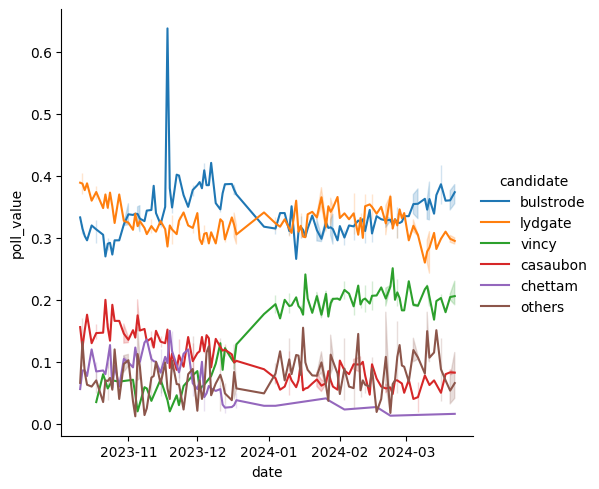

In [73]:
df_melt = df.melt(id_vars=['date', 'pollster', 'sample', 'sample_exclusions', 'alt_survey'], var_name='candidate', value_name='poll_value')
sns.relplot(data=df_melt, x='date', y='poll_value', hue='candidate', kind='line')

/Users/kbeebe/.pyenv/versions/3.10.9/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


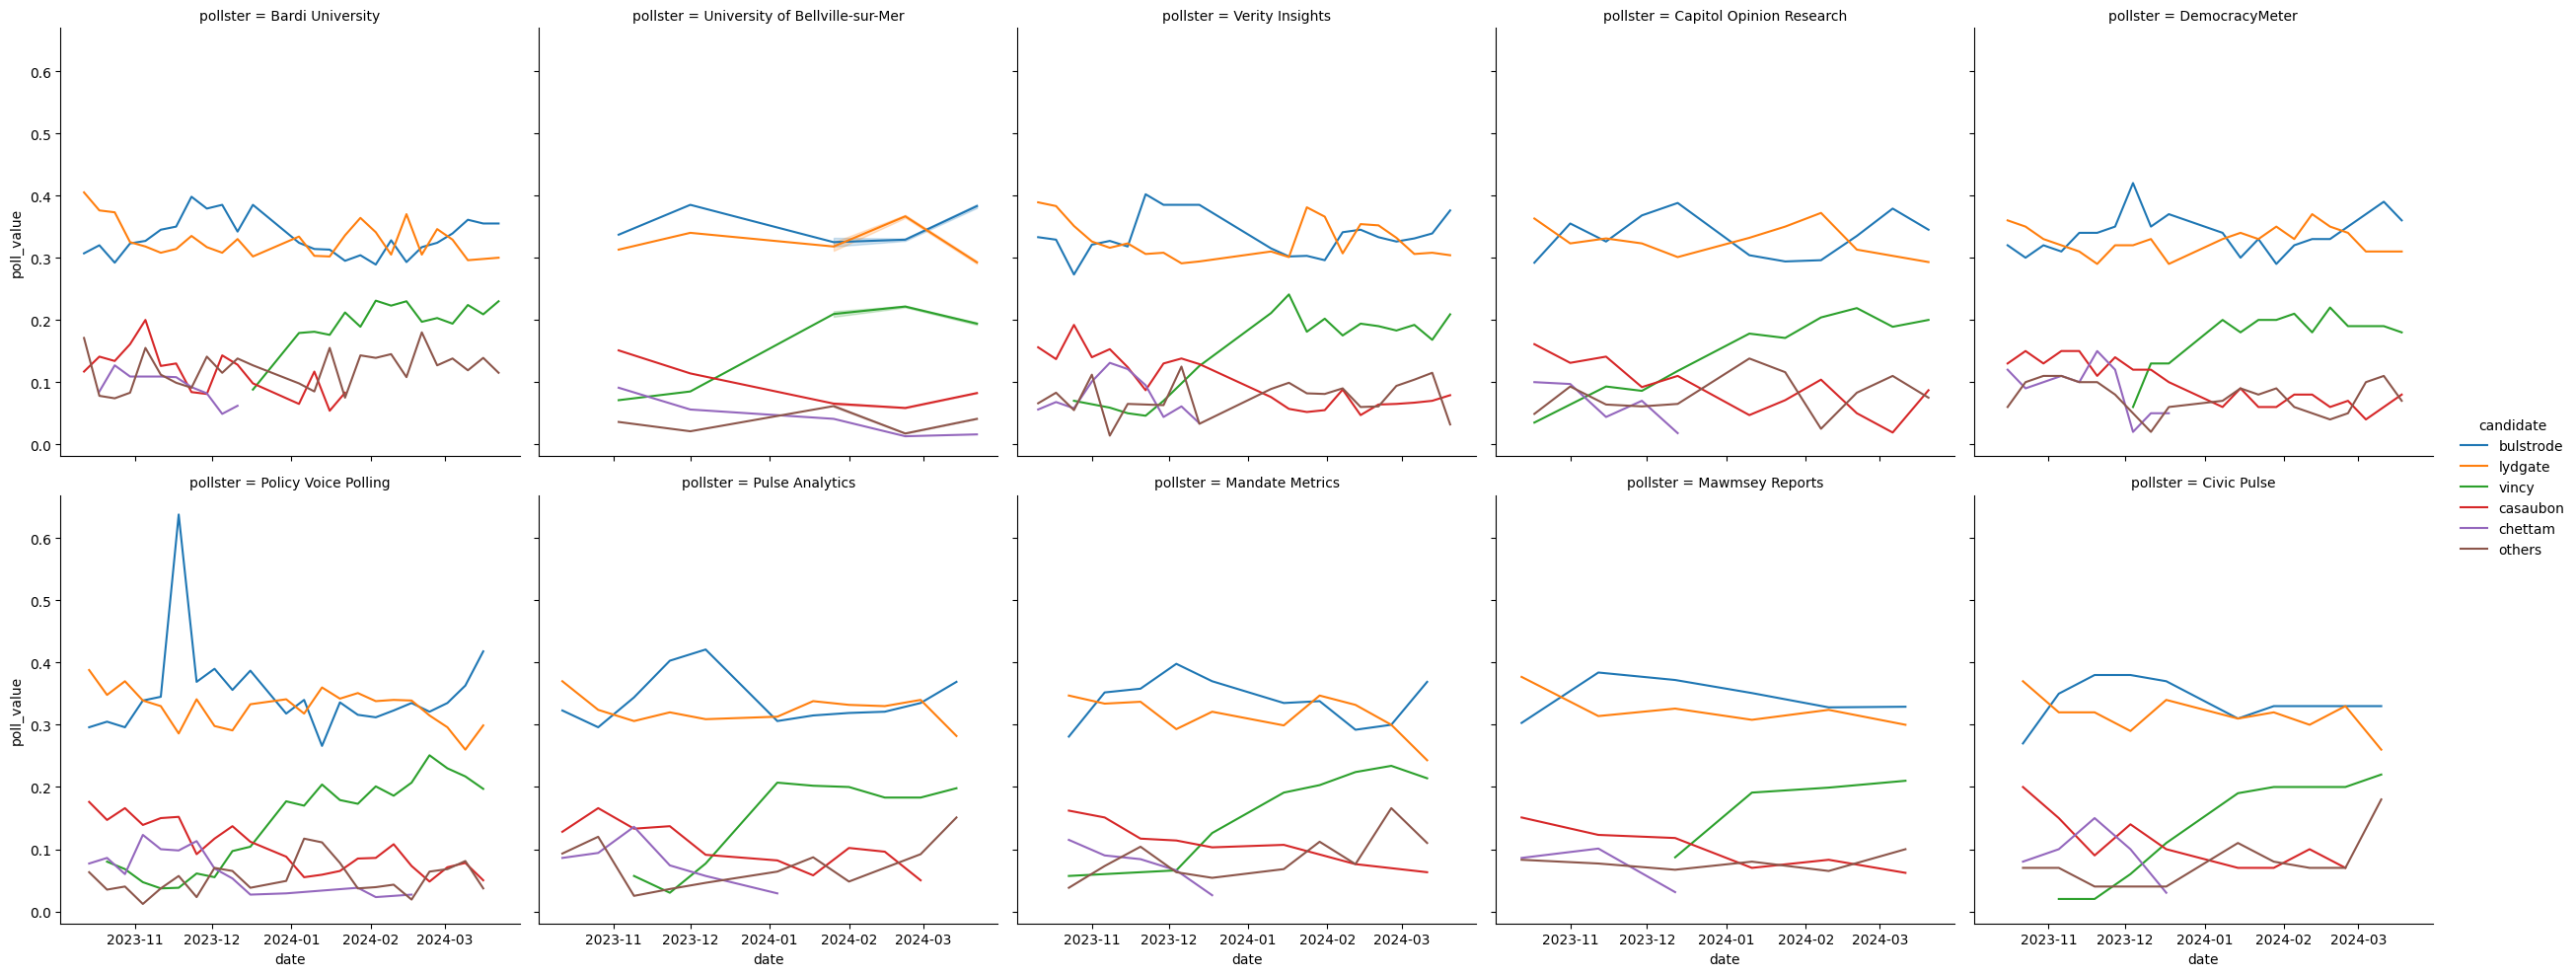

In [74]:
sns.relplot(data=df_melt, x='date', y='poll_value', hue='candidate', col='pollster', kind='line', col_wrap=5)

/Users/kbeebe/.pyenv/versions/3.10.9/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


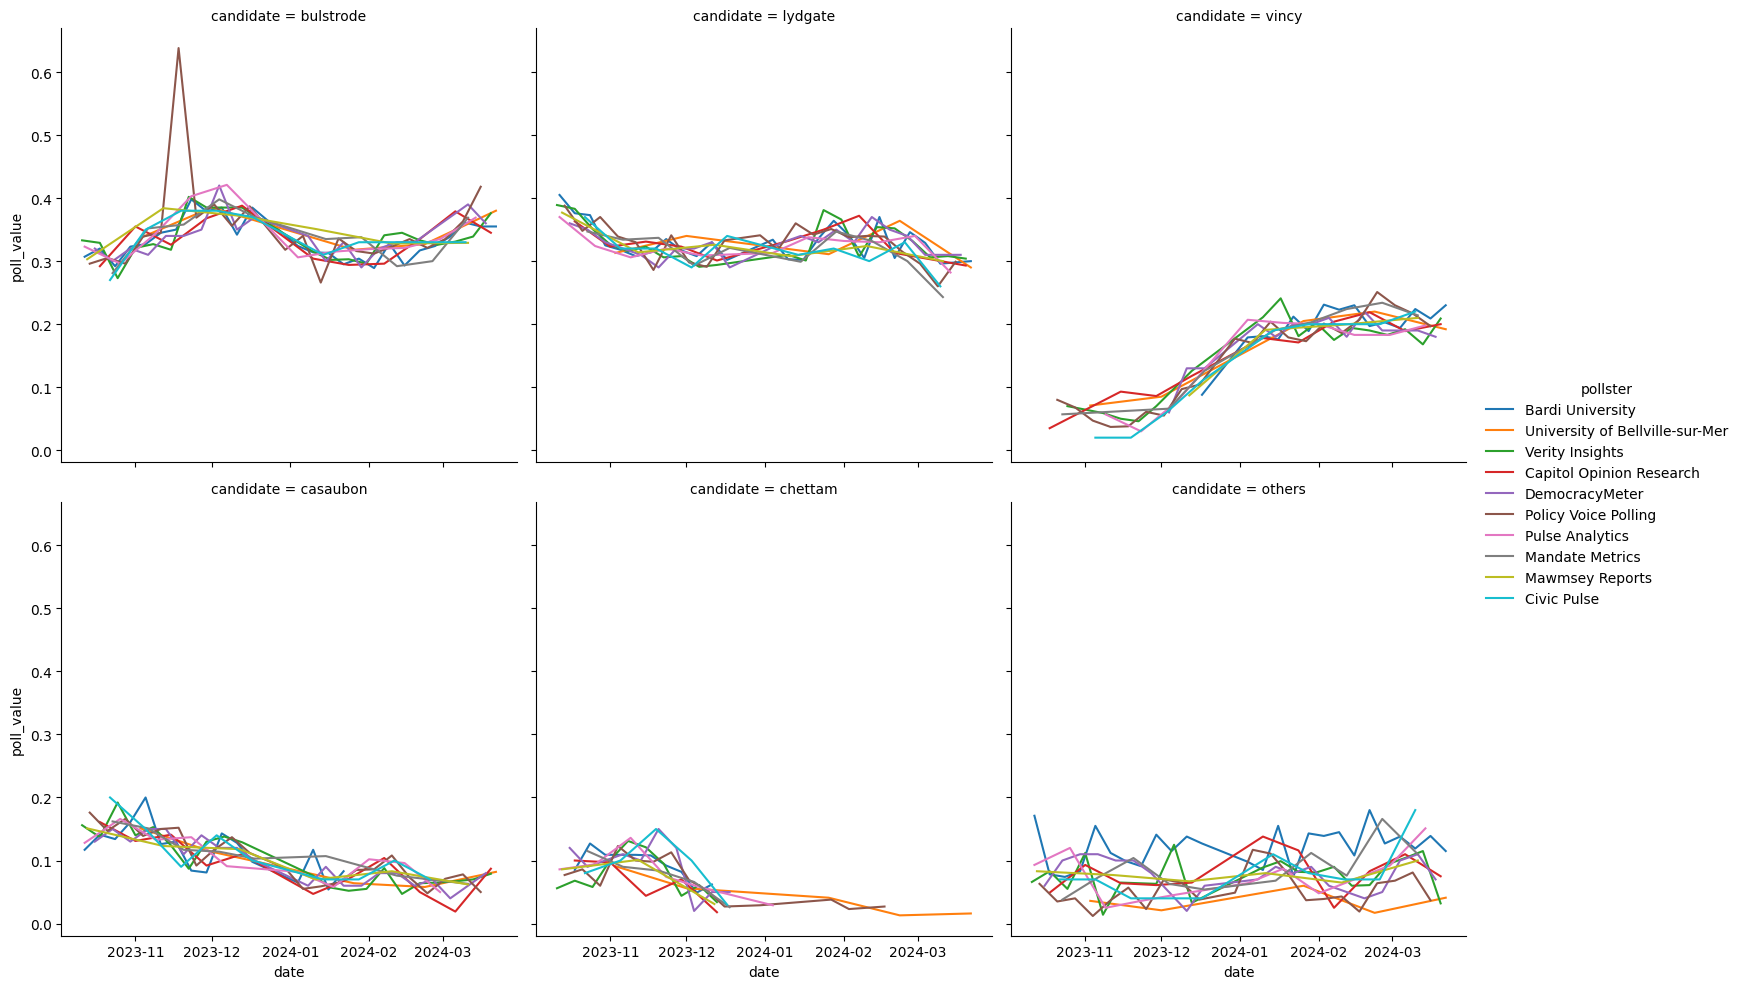

In [85]:
sns.relplot(data=df_melt[df_melt['alt_survey'] == 0], x='date', y='poll_value', hue='pollster', col='candidate', kind='line', col_wrap=3)

TypeError: reduction operation 'argmin' not allowed for this dtype

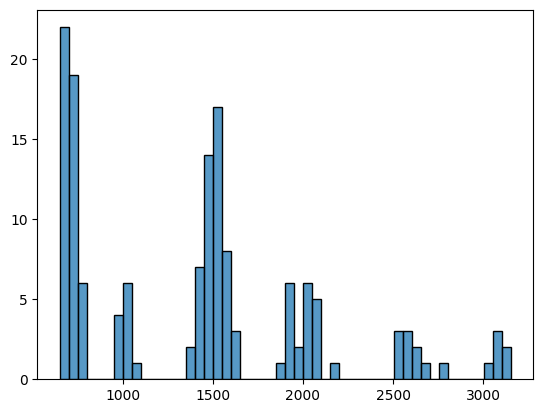

In [95]:
sns.histplot(data=df, x='sample', bins=50)

In [104]:
df[df['bulstrode'] > .5]

,date,pollster,sample,bulstrode,lydgate,vincy,casaubon,chettam,others,sample_exclusions,alt_survey
109,2023-11-18,Policy Voice Polling,1419,0.638,0.286,0.038,0.152,0.098,0.057,0,0


In [87]:
df['summed_poll'] = df['bulstrode'] + df['lydgate'] + df['vincy'] + df['casaubon'] + df['chettam'] + df['others']

In [88]:
df[df['summed_poll'] > 1.1]

,date,pollster,sample,bulstrode,lydgate,vincy,casaubon,chettam,others,sample_exclusions,alt_survey,summed_poll
109,2023-11-18,Policy Voice Polling,1419,0.638,0.286,0.038,0.152,0.098,0.057,0,0,1.269


In [89]:
df[df['summed_poll'] < .9]

,date,pollster,sample,bulstrode,lydgate,vincy,casaubon,chettam,others,sample_exclusions,alt_survey,summed_poll


Exclusion criteria
- polls with hypothetical scenarios